In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

In [2]:
dataset = "athletes"
key_idx = -1

In [3]:
keys = ["random",  "cluster_random", "influencer","cluster_influencer"]
df_name = "outputs/%s_%s.csv"%(dataset, keys[key_idx])

df = pd.read_csv(df_name, index_col="index")
df = df.drop(["label"], axis=1)
print(df.shape)

df_means = pd.read_csv("master/outputs/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/outputs/embeddings/%s_embedding.csv"%dataset)
df_edges = pd.read_csv("master/data/%s_edges.csv"%dataset, index_col="node_1")
with open('master/outputs/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)
    
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())})
df_label["index"] = df_label["index"].astype(int)
df_label = df_label.set_index("index")
df_label = df_label.sort_index()
print(df_label.shape)

n_class = len(np.unique(df_label.label))

(13866, 999)
(13866, 1)


explained var 0.91


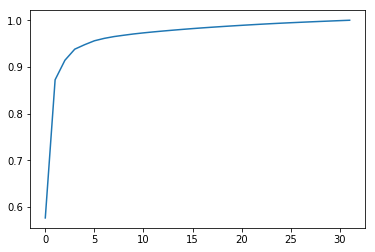

In [4]:
pca = PCA().fit(df_emb)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
print("explained var %.2f"%sum(pca.explained_variance_ratio_[:3]))

In [5]:
pca = PCA(3)
projected = pca.fit_transform(df_emb)

In [6]:
df_emb = pd.DataFrame(projected, index=df_emb.index)

In [7]:
df_emb["norm"] = np.linalg.norm(df_emb, axis=1)
df_emb["label"] = df_label.label
df_emb.sort_values("norm", inplace=True)

df_emb.head()

,0,1,2,norm,label
9965,-2.909158,0.661694,-0.529397,3.030066,9
10877,-2.065542,-2.397082,-0.898836,3.289434,9
960,-2.809388,0.887993,-1.768353,3.436316,9
1510,-3.222963,-1.168141,-0.848923,3.531673,9
10872,-3.498913,0.670808,-1.217513,3.764932,9


In [8]:
df_emb = df_emb.reset_index()

In [9]:
df_label = df_emb[["label"]]
df_emb = df_emb.drop(["norm", "label"], axis=1)

In [10]:
colors_choice = ["C0", "C1", "C2", "C3", "C4", "C8", "C9"]
colors = [colors_choice[i%len(colors_choice)] for i in range(n_class)]
colors.append("k")

In [11]:
df_label.head()

,label
0,9
1,9
2,9
3,9
4,9


In [12]:
duration = 3
fps = 48

columns = df.columns
end = len(df_emb)
# end = duration * fps

batch = int(end / (duration * fps))
print("batch", batch)

frames = []
for i in range(end // batch + 1):
    idx_end = min(end - 1, (i + 1) * batch)
    frames.append(idx_end)
    
alpha = 0.05

batch 96


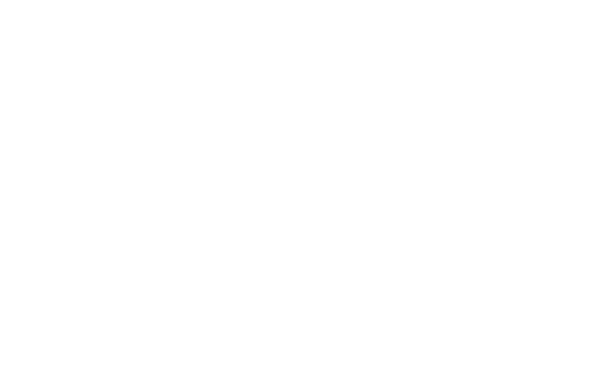

In [13]:
fig = plt.figure(figsize=(8, 5))
ax = Axes3D(fig)

i = 0

col = df[columns[-1]]
labels = df_label.label.values.copy()
# labels[col] = len(colors)

ax.cla()
ax.scatter(df_emb.iloc[:i, 1], df_emb.iloc[:i, 2], df_emb.iloc[:i, 3],
           c=labels[:i], cmap=matplotlib.colors.ListedColormap(colors), alpha=alpha)

limit = 14
ax.set_xlim(-limit + 3, limit)
ax.set_ylim(-limit, limit)
ax.set_zlim(-limit + 10, limit - 3)

ax._axis3don = False
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

In [14]:
def update(i):
    if i % batch == 0:
        print('frame %i'%i, end="\r")
    
    ax.cla()
    ax.scatter(df_emb.iloc[:i, 1], df_emb.iloc[:i, 2], df_emb.iloc[:i, 3],
               c=labels[:i], cmap=matplotlib.colors.ListedColormap(colors), alpha=alpha)
    
    ax.set_xlim(-limit + 3, limit)
    ax.set_ylim(-limit, limit)
    ax.set_zlim(-limit + 10, limit - 3)
    
    ax._axis3don = False
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    return ax

anim = FuncAnimation(fig, update, frames=frames, interval=1000 / fps)

fname = '%s_%is_%ifps_alpha_%.2f_end%i.gif'%(df_name, duration, fps, alpha, end)
anim.save(fname, dpi=80, writer='imagemagick')
print(fname)

plt.close()

outputs/athletes_cluster_influencer.csv_3s_48fps_alpha_0.05_end13866.gif
